In [1]:
import keras

2025-08-01 15:29:28.485829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 15:29:28.523904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-01 15:29:29.441207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/sorted/",
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    seed=2347,
    subset="both"
)

Found 1451 files belonging to 9 classes.
Using 1161 files for training.
Using 290 files for validation.


2025-08-01 15:29:44.872835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-01 15:29:45.123022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-01 15:29:45.123510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
import tensorflow as tf

def create_model(num_classes):

    pretrained_model = tf.keras.applications.EfficientNetV2S(
                        input_shape=(224,224, 3),
                        include_top=False,
                        weights='imagenet',
                        pooling='avg'
                        )
    pretrained_model.trainable = False
    x = keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    output = keras.layers.Dense(num_classes, activation='softmax')(x)
    final_model = keras.Model(pretrained_model.input, output)

    final_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return final_model

    # print(final_model.summary())

In [5]:
num_classes = len(train_ds.class_names)

model = create_model(num_classes)

In [30]:
from matplotlib import pyplot as plt


def plot_history(hist):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

In [7]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, batch_size=32, callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1754055014.816378  107593 service.cc:145] XLA service 0x7e5938002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754055014.816417  107593 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-01 15:30:15.289616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-01 15:30:16.760720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1754055038.405092  108044 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_23430', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1754055039.172663  108046 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_23250', 32 bytes spill stores, 32 bytes spill loads

I0000 00:0

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6304 - loss: 1.2874

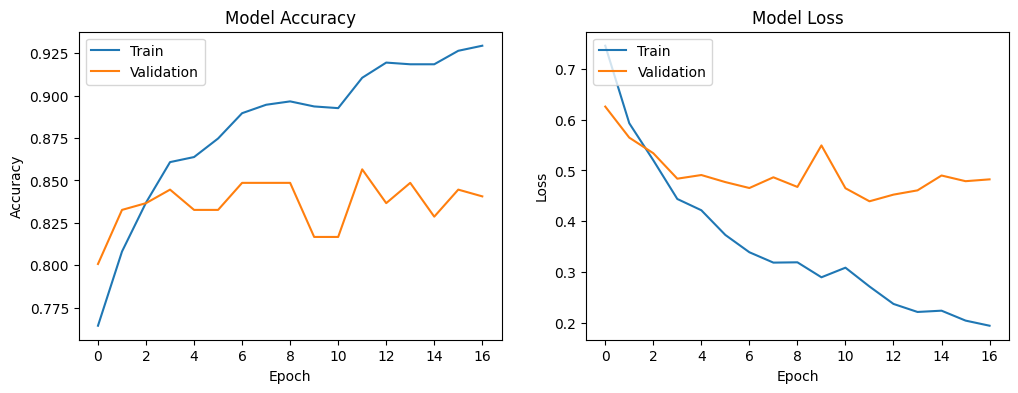

In [55]:
plot_history(history)

In [56]:
import glob
import os
import shutil
import cv2 as cv
import numpy as np

for class_name in train_ds.class_names:
    os.makedirs(os.path.join("/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/", class_name), exist_ok=True)

images = glob.glob("/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/*.jpg")
print(images[:10], len(images))
preprocess = tf.keras.applications.efficientnet_v2.preprocess_input
img_size = (224,224)

for img in images:
    # print(img)
    image = cv.imread(img, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # 3. Resize
    image = cv.resize(image, img_size).astype("float32")    
    image = preprocess(image) 
    
    input_tensor = np.expand_dims(image, axis=0)
    predictions = model.predict(input_tensor)
    pred_class = np.argmax(predictions)
    # print(pred_class)
    # print(train_ds.class_names[pred_class])
    target_path = os.path.join(os.path.dirname(img), train_ds.class_names[pred_class])
    shutil.move(img, target_path)
    

['/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/fc48c1663d9322b1bb9b9a53f186c3d12be2214d.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/a2c8b6af46cb52e3fc51e3dc394f38849599566b.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/f71b9fbffd2fd7d366f32c95e82b59cafa0b8da9.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/b347a4c6f358479e3385be1c0b97f481fd69834b.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/aef0f8e9b07bd8958c4d101f1496546a691ff545.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/5a31997b4babee18d10c9fa9b1b88a6daf05f471.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_dataset/Casual T-shirts/fb0c726e5398cd5f590cbc1ee5ec3d9307d49a20.jpg', '/home/cat/projects/CV-stuff/latl/datasets/multilabel_fashion_datase

In [60]:
model.save("/home/cat/projects/CV-stuff/latl/models/t_shirts.keras")
model.save_weights("/home/cat/projects/CV-stuff/latl/models/t_shirts.weights.h5")

In [1]:
!pip install label-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 7.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.7/767.7 KB 7.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.5 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 8.6 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.6 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.0 MB/s eta 0:00:00a 0:00:0